# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [2]:
#Librerías 
import numpy as np
import pandas as pd
# Para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

from seaborn import heatmap
from scipy import stats

# Para dividir el dataset en train  y test
from sklearn.model_selection import train_test_split

# Algoritmo del Gradiente Descendente
from sklearn.linear_model import SGDClassifier

# Algoritmo del Árbol de Decisión
from sklearn.tree import (DecisionTreeClassifier, plot_tree)

# Validación Cruzada 
from sklearn.model_selection import GridSearchCV

# Para calcular métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                            roc_curve, roc_auc_score, precision_recall_curve)

# Para la Normalización cuando utilizamos SGDC
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [3]:
#dataset = pd.read_csv("./data/loan_data.csv", comment="#")

datos_credito = pd.read_csv("https://raw.githubusercontent.com/DiploDatos/IntroduccionAprendizajeAutomatico/master/data/loan_data.csv", comment="#")


# División entre instancias y etiquetas
X, y = datos_credito.iloc[:, 1:], datos_credito.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

**1.** Revisamos el dataset para conocer un poco más de los datos.

In [4]:
datos_credito

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001


In [5]:
datos_credito.describe()  

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,0.166667,19111.758360,76316.051780,107321.088457,8.900216,0.187702,0.319849,180.300783,1.128910,21.857066,34.573408
std,0.372779,11000.345961,46227.026585,56039.685066,7.552677,0.704882,0.928452,84.838308,1.664555,9.510840,9.308794
min,0.000000,1700.000000,5627.000000,21144.000000,0.000000,0.000000,0.000000,0.486711,0.000000,0.000000,0.838118
25%,0.000000,12000.000000,48984.750000,70787.250000,3.000000,0.000000,0.000000,116.970718,0.000000,16.000000,29.427210
50%,0.000000,17000.000000,67201.000000,94198.000000,7.000000,0.000000,0.000000,174.967815,1.000000,21.000000,35.363407
75%,0.000000,23900.000000,93731.500000,122976.250000,13.000000,0.000000,0.000000,232.261800,2.000000,27.000000,39.357987
max,1.000000,89800.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,13.000000,65.000000,144.189001


**2.** El target o variable objetivo puede tomar dos valores 1 ó 0 (1 si no se cumplieron las obligaciones del préstamo, por el contrario 0 si el préstamo fue pagado). Esta variable es la que queremos predecir y representa el cumplimiento por parte del solicitante de las obligaciones adquiridas al tomar un préstamo.

**3. Variables oatributos disponibles:**

TARGET: Dicha variable puede tomar dos valores 1 ó 0  (1 = no se cumplieron las obligaciones del préstamo; 0 = se cumplió la obligación del préstamo, es decir, que fue pagado en su totalidad. Esta variable es la que queremos predecir.

LOAN: Cantidad de dinero solicitado en el préstamo.

MORTDUE: Suma adeudada en la hipoteca existente.

VALUE: Valor de la propiedad actual.

YOJ: Años en el trabajo actual.

DEROG: Número de informes negativos importantes.

DELINQ: Número de líneas de crédito en mora.

CLAGE: Edad de la línea comercial más antigua en meses.

NINQ: Número de líneas de crédito recientes.

CLNO: Número de líneas de crédito.

DEBTINC: Relación Deuda/Ingreso.

** 4.Posibles Variables que influyen sobre la variable objetivo:**

* DEBTINC: Relación Deuda/Ingreso  
* DEROG: Número de informes negativos.
* DELINQ: Número de líneas de crédito en mora y por último, 
* CLNO: Número de líneas de crédito.

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


#### Antes de avanzar es necesario normalizar el dataset para luego aplicar los algoritmos de clasificación. 

In [6]:
# SGDClassifier es sensitivo a las magnitudes de los valores, por esta razón a continuación se realiza un escalado o normalización
escalado = StandardScaler()
escalado.fit(X_train)
X_train = escalado.transform(X_train)
X_test  = escalado.transform(X_test)  

#from sklearn.preprocessing import StandardScaler
##scaler = StandardScaler()
#scaler.fit(X_train)  # Don't cheat - fit only on training data
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test) 

### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [7]:
# Ejecutamos el algoritmo del gradiente descendiente con los valores por omisión
modelGD = SGDClassifier(random_state=0)
modelGD.get_params   # para conocer los valores por omisión que utiliza


<bound method BaseEstimator.get_params of SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)>

In [8]:
# Entrenamiento
modelGD.fit(X_train, y_train);
#GD.fit(X_train, y_train);

In [9]:
#Predicción 
y_train_predict = modelGD.predict(X_train)
y_test_predict = modelGD.predict (X_test)

In [10]:
# Calculamos las métricas más comunes (Ac: accuracy, Pr:precisión, Re: recall, F1, CM:matriz de confusión)
print('Resultados obtenidos en Entrenamiento')
print('------------------------------------------------------------')
print(classification_report(y_train, y_train_predict, digits=3))


Resultados obtenidos en Entrenamiento
------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.891     0.966     0.927      1232
           1      0.714     0.418     0.528       251

    accuracy                          0.873      1483
   macro avg      0.803     0.692     0.727      1483
weighted avg      0.861     0.873     0.859      1483



In [11]:
print('matriz de confusión')
mtx_confusion_train= confusion_matrix(y_train, y_train_predict)
print(mtx_confusion_train)

matriz de confusión
[[1190   42]
 [ 146  105]]


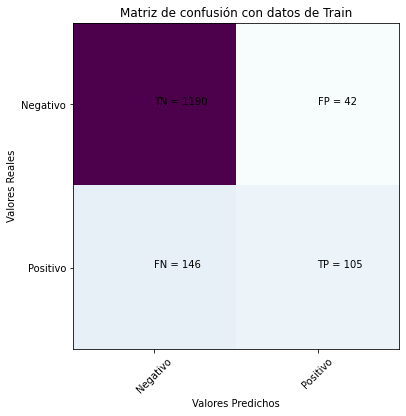

In [12]:
# graficamos la matriz de confusión
plt.figure(figsize=(10,6))  
plt.clf()
plt.imshow(mtx_confusion_train, interpolation='nearest', cmap=plt.cm.BuPu)#Orangescmap=plt.mtx_confusion_test.Wistia from matplotlib.colors import ListedColormap
classNames = ['Negativo','Positivo']
plt.title('Matriz de confusión con datos de Train')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(mtx_confusion_train[i][j]))
plt.show()

In [13]:
# Calculamos las métricas más comunes (Ac: accuracy, Pr:precisión, Re: recall, F1, CM:matriz de confusión)
print('Resultados obtenidos en Prueba')
print('------------------------------------------------------------')
print(classification_report(y_test, y_test_predict, digits=4))



Resultados obtenidos en Prueba
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8882    0.9649    0.9250       313
           1     0.6452    0.3448    0.4494        58

    accuracy                         0.8679       371
   macro avg     0.7667    0.6548    0.6872       371
weighted avg     0.8502    0.8679    0.8506       371



In [14]:
print('matriz de confusión')
mtx_confusion_test= confusion_matrix(y_test, y_test_predict)
print(mtx_confusion_test)

matriz de confusión
[[302  11]
 [ 38  20]]


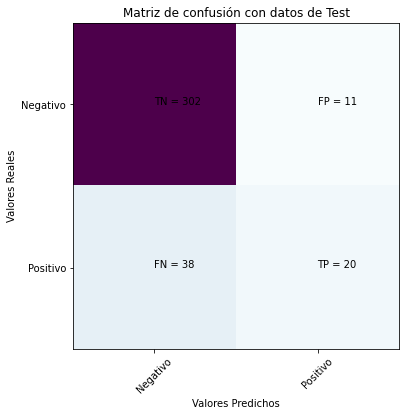

In [15]:
# graficamos la matriz de confusión
plt.figure(figsize=(10,6))  
plt.clf()
plt.imshow(mtx_confusion_test, interpolation='nearest', cmap=plt.cm.BuPu)#BuPu Oranges cmap=plt.mtx_confusion_test.RdPu from matplotlib.colors import ListedColormap
classNames = ['Negativo','Positivo']
plt.title('Matriz de confusión con datos de Test')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(mtx_confusion_test[i][j]))
plt.show()

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [42]:
modelGD2 = SGDClassifier(random_state=0)

In [17]:
param_grid_GD2 = {
  'learning_rate': ['optimal','constant', 'adaptive'],  #diferents opciones de tasa de entrenamiento
  'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'], #diferentes opciones de función de costo
  'l1_ratio': list(np.linspace(0, 1, 11))+[0.15], # diferentes opciones de tasas de regularización
  'alpha': np.logspace(-5, 0, 6),
  'eta0': np.logspace(-5, 0, 6)
}

In [50]:
from sklearn.model_selection import ParameterSampler

for params in ParameterSampler(param_grid_GD2, 4, random_state=0):
    print(params)
    #model = SGDClassifier(**params, random_state=0)
    

{'loss': 'hinge', 'learning_rate': 'adaptive', 'l1_ratio': 0.15, 'eta0': 1e-05, 'alpha': 0.01}
{'loss': 'squared_hinge', 'learning_rate': 'optimal', 'l1_ratio': 0.1, 'eta0': 1e-05, 'alpha': 0.01}
{'loss': 'log', 'learning_rate': 'adaptive', 'l1_ratio': 0.5, 'eta0': 1.0, 'alpha': 0.0001}
{'loss': 'hinge', 'learning_rate': 'optimal', 'l1_ratio': 0.8, 'eta0': 0.1, 'alpha': 0.01}


In [44]:
# Entrenamiento
modelGD2.fit(X_train, y_train);

In [45]:
#Predicción 
y_train_predict = modelGD2.predict(X_train)
y_test_predict = modelGD2.predict (X_test)

In [71]:
grid_gd2 = GridSearchCV(modelGD2, param_grid_GD2, cv=5, scoring=['accuracy'], refit= False) #sino ponfo refit en false genera error
grid_gd2.fit(X_train, y_train)  #gd2:por gradiente descendiente 


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=0,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, ver...
                         'eta0': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'l1_ratio': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                      0.5, 0.6000000000000001,
                                      0.7000000000000001, 0.8, 0.9, 1.0, 0.15],
    

In [58]:
# a los resultados lo guardamos como dataframe
grid_gd2_df = pd.DataFrame(grid_gd2.cv_results_)


AttributeError: ignored

In [52]:
grid_gd2_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_eta0', 'param_l1_ratio', 'param_learning_rate',
       'param_loss', 'params', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
       'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy'],
      dtype='object')

In [55]:
grid_gd2_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_eta0,param_l1_ratio,param_learning_rate,param_loss,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.006226,0.001544,0.000728,0.000084,1e-05,1e-05,0,optimal,hinge,"{'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0....",0.781145,0.804714,0.818182,0.854730,0.814189,0.814592,0.023834,4561
1,0.011450,0.003816,0.000657,0.000034,1e-05,1e-05,0,optimal,log,"{'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0....",0.831650,0.784512,0.787879,0.871622,0.854730,0.826078,0.034966,4345
2,0.005061,0.000462,0.000564,0.000028,1e-05,1e-05,0,optimal,modified_huber,"{'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0....",0.811448,0.808081,0.851852,0.773649,0.854730,0.819952,0.030280,4477
3,0.004823,0.000573,0.000540,0.000025,1e-05,1e-05,0,optimal,squared_hinge,"{'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0....",0.804714,0.774411,0.811448,0.837838,0.783784,0.802439,0.022240,4813
4,0.011753,0.000206,0.000662,0.000025,1e-05,1e-05,0,constant,hinge,"{'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0....",0.861953,0.858586,0.851852,0.868243,0.851351,0.858397,0.006358,2629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5179,0.002463,0.000346,0.000432,0.000017,1,1,0.15,constant,squared_hinge,"{'alpha': 1.0, 'eta0': 1.0, 'l1_ratio': 0.15, ...",0.649832,0.831650,0.828283,0.722973,0.168919,0.640331,0.245389,5173
5180,0.006268,0.000363,0.000500,0.000019,1,1,0.15,adaptive,hinge,"{'alpha': 1.0, 'eta0': 1.0, 'l1_ratio': 0.15, ...",0.831650,0.831650,0.828283,0.831081,0.831081,0.830749,0.001259,4141
5181,0.013735,0.000885,0.000638,0.000043,1,1,0.15,adaptive,log,"{'alpha': 1.0, 'eta0': 1.0, 'l1_ratio': 0.15, ...",0.831650,0.831650,0.828283,0.831081,0.831081,0.830749,0.001259,4141
5182,0.007748,0.000410,0.000602,0.000035,1,1,0.15,adaptive,modified_huber,"{'alpha': 1.0, 'eta0': 1.0, 'l1_ratio': 0.15, ...",0.851852,0.851852,0.841751,0.854730,0.854730,0.850983,0.004792,3433


In [56]:
#Ranking_accuracy
grid_ordenado['Ranking_accuracy'].idxmin()

KeyError: ignored

In [ ]:
GSVC_ac = grid_ordenado.loc[grid_ordenado.Ranking_accuracy.idxmin()]
GSVC_pr = grid_ordenado.loc[grid_ordenado.Ranking_precision.idxmin()]
GSVC_re = grid_ordenado.loc[grid_ordenado.Ranking_recall.idxmin()]
GSVC_f1 = grid_ordenado.loc[grid_ordenado.Ranking_f1.idxmin()]
#GSVC_ov = grid_ordenado.loc[grid_ordenado.Ranking_overall.idxmin()]

In [ ]:
print(GSVC_ac)

In [ ]:
# Calculamos las métricas más comunes (Ac: accuracy, Pr:precisión, Re: recall, F1, CM:matriz de confusión)
print('Resultados obtenidos en Prueba')
print('------------------------------------------------------------')
print(classification_report(y_test, y_test_predict, digits=4))

In [ ]:
print('matriz de confusión')
mtx_confusion_test= confusion_matrix(y_test, y_test_predict)
print(mtx_confusion_test)

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [25]:
arbol_decision = DecisionTreeClassifier(random_state=0)

print('Parámetros utilizados: \n', np.array(list(arbol_decision.get_params(deep=False).items())))

Parámetros utilizados: 
 [['ccp_alpha' 0.0]
 ['class_weight' None]
 ['criterion' 'gini']
 ['max_depth' None]
 ['max_features' None]
 ['max_leaf_nodes' None]
 ['min_impurity_decrease' 0.0]
 ['min_impurity_split' None]
 ['min_samples_leaf' 1]
 ['min_samples_split' 2]
 ['min_weight_fraction_leaf' 0.0]
 ['presort' 'deprecated']
 ['random_state' 0]
 ['splitter' 'best']]


Entrenamiento

In [26]:
arbol_decision.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Predicción

In [27]:
y_train_pred_arbol = arbol_decision.predict(X_train)
y_test_pred_arbol  = arbol_decision.predict(X_test)

In [28]:
print('Profundidad máxima del árbol:', arbol_decision.get_depth())
print('Cantidad de hojas del árbol:', arbol_decision.get_n_leaves())

Profundidad máxima del árbol: 22
Cantidad de hojas del árbol: 141


Gráficos

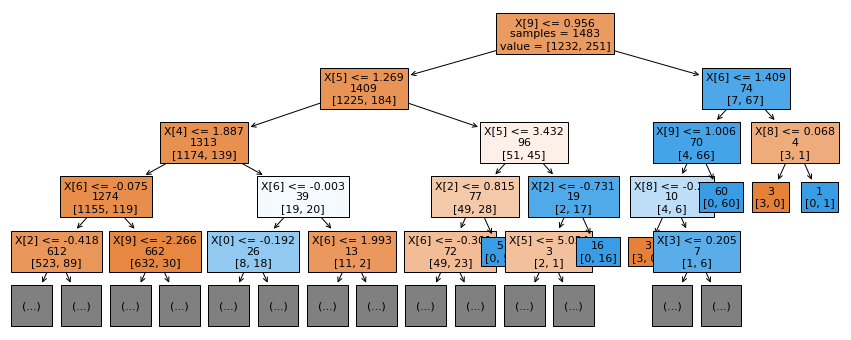

In [29]:
# muestro los arboles generado por el modelo con 4 ramas de profundidad
plt.figure(figsize=(15,6))
plot_tree(arbol_decision, impurity=False, filled=True, max_depth= 4, fontsize=11, label='root')
plt.show()

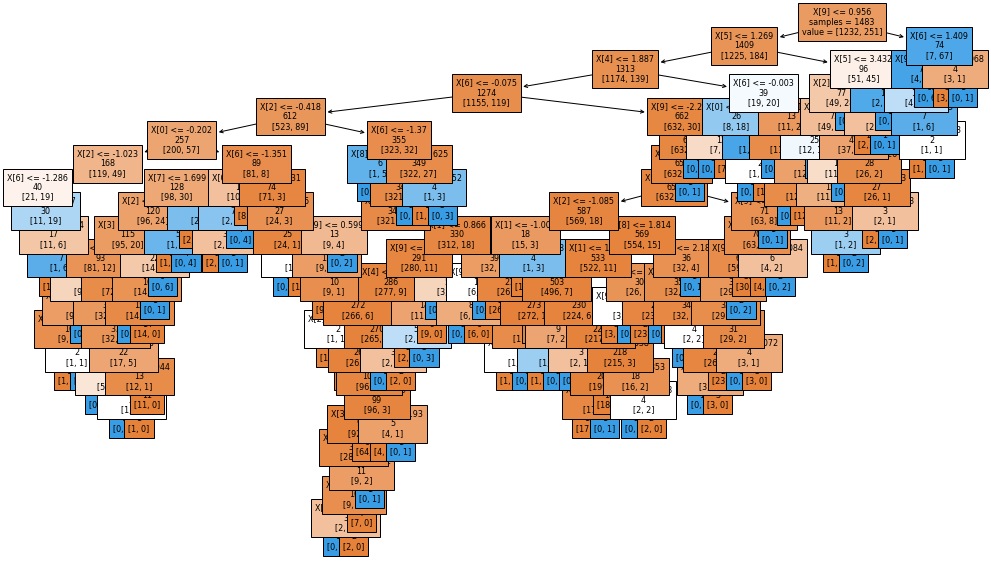

In [30]:
# árbol sin especificar el nro. de ramas
plt.figure(figsize=(17,10))
plot_tree(arbol_decision, impurity=False, fontsize=8, filled=True, label='root')  #filled=True,
plt.show()

In [33]:
# Calculamos las métricas más comunes (Ac: accuracy, Pr:precisión, Re: recall, F1, CM:matriz de confusión)
print('Resultados obtenidos en Entrenamiento')
print('------------------------------------------------------------')
print(classification_report(y_train, y_train_pred_arbol, digits=3))

Resultados obtenidos en Entrenamiento
------------------------------------------------------------
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1232
           1      1.000     1.000     1.000       251

    accuracy                          1.000      1483
   macro avg      1.000     1.000     1.000      1483
weighted avg      1.000     1.000     1.000      1483



In [35]:
print('Matriz de confusión con datos de entrenamiento')
mtx_confusion_train_arbol= confusion_matrix(y_train, y_train_pred_arbol)
print(mtx_confusion_train_arbol)

matriz de confusión
[[1232    0]
 [   0  251]]


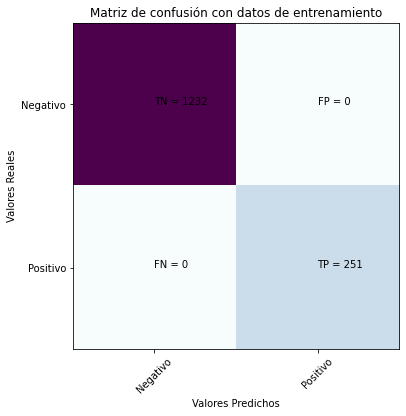

In [38]:
# graficamos la matriz de confusión con datos de train o entrenamiento
plt.figure(figsize=(10,6))  
plt.clf()
plt.imshow(mtx_confusion_train_arbol, interpolation='nearest', cmap=plt.cm.BuPu)#Orangescmap=plt.mtx_confusion_test.Wistia from matplotlib.colors import ListedColormap
classNames = ['Negativo','Positivo']
plt.title('Matriz de confusión con datos de entrenamiento')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(mtx_confusion_train_arbol[i][j]))
plt.show()

In [34]:
# Calculamos las métricas más comunes (Ac: accuracy, Pr:precisión, Re: recall, F1, CM:matriz de confusión)
print('Resultados obtenidos en Prueba')
print('------------------------------------------------------------')
print(classification_report(y_test, y_test_pred_arbol, digits=3))

Resultados obtenidos en Prueba
------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.932     0.927     0.929       313
           1      0.617     0.638     0.627        58

    accuracy                          0.881       371
   macro avg      0.775     0.782     0.778       371
weighted avg      0.883     0.881     0.882       371



In [36]:
print('Matriz de confusión con datos de prueba')
mtx_confusion_test_arbol= confusion_matrix(y_test, y_test_pred_arbol)
print(mtx_confusion_test_arbol)

Matriz de confusión con datos de entrenamiento
[[290  23]
 [ 21  37]]


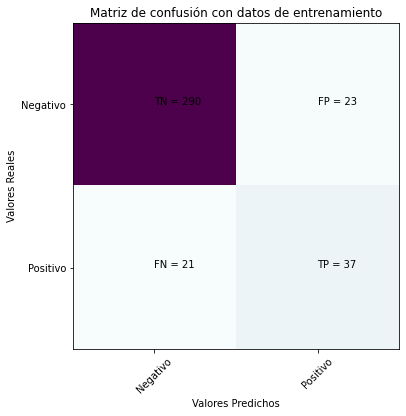

In [39]:
# graficamos la matriz de confusión con datos de test o prueba
plt.figure(figsize=(10,6))  
plt.clf()
plt.imshow(mtx_confusion_test_arbol, interpolation='nearest', cmap=plt.cm.BuPu)#Orangescmap=plt.mtx_confusion_test.Wistia from matplotlib.colors import ListedColormap
classNames = ['Negativo','Positivo']
plt.title('Matriz de confusión con datos de entrenamiento')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(mtx_confusion_test_arbol[i][j]))
plt.show()

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


**Ärbol de decisión**

In [63]:
arbol_decision_con_param = DecisionTreeClassifier(random_state=0)

**Opciones de parámetros**

In [66]:
param_arbol_decision = [
  {'splitter': ['best'],
          'criterion': ['gini', 'entropy'],
          'max_depth': list(np.arange(4,20,2)),
          'min_samples_leaf': np.arange(1,10)
          },
  {'splitter': ['random'],
          'criterion': ['gini', 'entropy'],
          'max_depth': list(np.arange(4,20,2)),
          'min_samples_leaf': np.arange(1,10)
          }
]

**Utilizamos grid-search con 5-fold cross-validation**

In [67]:
grid_ad = GridSearchCV(arbol_decision_con_param, param_arbol_decision, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False)
grid_ad.fit(X_train, y_train);

In [68]:
# los resultados de la búsqueda lo guardamos como dataframe
arbol_decision_con_param_df = pd.DataFrame(grid_ad.cv_results_)

In [69]:
# observamos los resultados obtenidos
arbol_decision_con_param_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_splitter,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision_weighted,split1_test_precision_weighted,split2_test_precision_weighted,split3_test_precision_weighted,split4_test_precision_weighted,mean_test_precision_weighted,std_test_precision_weighted,rank_test_precision_weighted,split0_test_recall_weighted,split1_test_recall_weighted,split2_test_recall_weighted,split3_test_recall_weighted,split4_test_recall_weighted,mean_test_recall_weighted,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0.004754,0.000542,0.003340,0.000401,gini,4,1,best,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.858586,0.872054,0.892256,0.898649,0.871622,0.878633,0.014701,18,0.840943,0.861941,0.894380,0.904361,0.878892,0.876103,0.022703,2,0.858586,0.872054,0.892256,0.898649,0.871622,0.878633,0.014701,18,0.841657,0.850607,0.874773,0.881670,0.839892,0.857720,0.017268,113
1,0.004258,0.000077,0.003042,0.000282,gini,4,2,best,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.858586,0.872054,0.892256,0.898649,0.864865,0.877282,0.015568,24,0.840943,0.861941,0.894380,0.904361,0.863879,0.873101,0.023125,11,0.858586,0.872054,0.892256,0.898649,0.864865,0.877282,0.015568,24,0.841657,0.850607,0.874773,0.881670,0.831465,0.856034,0.019226,120
2,0.004206,0.000082,0.002878,0.000066,gini,4,3,best,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.861953,0.875421,0.895623,0.898649,0.868243,0.879978,0.014675,8,0.845750,0.866275,0.897704,0.904361,0.868047,0.876427,0.021667,1,0.861953,0.875421,0.895623,0.898649,0.868243,0.879978,0.014675,8,0.846419,0.855610,0.879550,0.881670,0.837145,0.860079,0.017764,95
3,0.004208,0.000043,0.002985,0.000211,gini,4,4,best,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.861953,0.875421,0.892256,0.898649,0.868243,0.879304,0.014003,12,0.845750,0.866275,0.894380,0.904361,0.868047,0.875763,0.021046,3,0.861953,0.875421,0.892256,0.898649,0.868243,0.879304,0.014003,12,0.846419,0.855610,0.874773,0.881670,0.837145,0.859124,0.016793,106
4,0.004297,0.000092,0.002944,0.000082,gini,4,5,best,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.861953,0.875421,0.892256,0.898649,0.868243,0.879304,0.014003,12,0.845317,0.866275,0.894380,0.904361,0.868047,0.875676,0.021170,4,0.861953,0.875421,0.892256,0.898649,0.868243,0.879304,0.014003,12,0.844406,0.855610,0.874773,0.881670,0.837145,0.858721,0.017114,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.002205,0.000079,0.002820,0.000043,entropy,18,5,random,"{'criterion': 'entropy', 'max_depth': 18, 'min...",0.841751,0.814815,0.835017,0.881757,0.858108,0.846289,0.022521,280,0.835631,0.798659,0.821748,0.871771,0.839951,0.833552,0.023928,276,0.841751,0.814815,0.835017,0.881757,0.858108,0.846289,0.022521,280,0.838379,0.805388,0.826849,0.871622,0.839004,0.836248,0.021467,248
284,0.002162,0.000056,0.002965,0.000170,entropy,18,6,random,"{'criterion': 'entropy', 'max_depth': 18, 'min...",0.845118,0.831650,0.882155,0.898649,0.841216,0.859757,0.025932,202,0.822734,0.821245,0.872680,0.897401,0.820221,0.846856,0.032152,201,0.845118,0.831650,0.882155,0.898649,0.841216,0.859757,0.025932,202,0.826577,0.825672,0.870857,0.885003,0.825545,0.846731,0.025866,179
285,0.002167,0.000073,0.002913,0.000111,entropy,18,7,random,"{'criterion': 'entropy', 'max_depth': 18, 'min...",0.858586,0.858586,0.848485,0.881757,0.844595,0.858402,0.012919,211,0.843928,0.843928,0.833246,0.876251,0.822171,0.843905,0.018068,219,0.858586,0.858586,0.848485,0.881757,0.844595,0.8

In [73]:
arbol_decision_con_param_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_leaf',
       'param_splitter', 'params', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_test_precision_weighted',
       'split1_test_precision_weighted', 'split2_test_precision_weighted',
       'split3_test_precision_weighted', 'split4_test_precision_weighted',
       'mean_test_precision_weighted', 'std_test_precision_weighted',
       'rank_test_precision_weighted', 'split0_test_recall_weighted',
       'split1_test_recall_weighted', 'split2_test_recall_weighted',
       'split3_test_recall_weighted', 'split4_test_recall_weighted',
       'mean_test_recall_weighted', 'std_test_recall_weighted',
       'rank_test_recall_weighted', 'split0_test_f1_weighted',
       'split1_test_f1

In [ ]:
#Nos quedamos con las columnas que nos interesan
Res_GSCV2 = Res_GSCV2[['param_criterion', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_splitter', 'params', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy','mean_test_precision_weighted',
       'std_test_precision_weighted','rank_test_precision_weighted', 'mean_test_recall_weighted', 'std_test_recall_weighted',
       'rank_test_recall_weighted', 'mean_test_f1_weighted', 'std_test_f1_weighted', 'rank_test_f1_weighted']]

### Ejercicio 3.3: Inspección del Modelo